# Hierarchical clustering based on a union of ellipsoids - Example of two spirals

In [1]:
using GeometricClusterAnalysis
using Plots
using Random

## Data generation

### Function to generate data

In [2]:
function noisy_nested_spirals(rng, nsignal, nnoise, σ, d)

    nmid = nsignal ÷ 2

    t1 = 6 .* rand(rng, nmid).+2
    t2 = 6 .* rand(rng, nsignal-nmid).+2

    x = zeros(nsignal)
    y = zeros(nsignal)

    λ = 5

    x[1:nmid] = λ .*t1.*cos.(t1)
    y[1:nmid] = λ .*t1.*sin.(t1)

    x[(nmid+1):nsignal] = λ .*t2.*cos.(t2 .- 0.8*π)
    y[(nmid+1):nsignal] = λ .*t2.*sin.(t2 .- 0.8*π)

    p0 = hcat(x, y)
    signal = p0 .+ σ .* randn(rng, nsignal, d)
    noise = 120 .* rand(rng, nnoise, d) .- 60

    points = collect(transpose(vcat(signal, noise)))
    colors = vcat(ones(nmid),2*ones(nsignal - nmid), zeros(nnoise))

    return Data{Float64}(nsignal + nnoise, d, points, colors)
end ;

### Parameters

In [3]:
nsignal = 2000 # number of signal points
nnoise = 400   # number of outliers
dim = 2       # dimension of the data
σ = 0.5 ;  # standard deviation for the additive noise

### Data generation

In [4]:
rng = MersenneTwister(1234)
data = noisy_nested_spirals(rng, nsignal, nnoise, σ, dim)
npoints = size(data.points,2)
print("The dataset contains ", npoints, " points, of dimension ", dim, ".")

The dataset contains 2400 points, of dimension 2.

### Data display

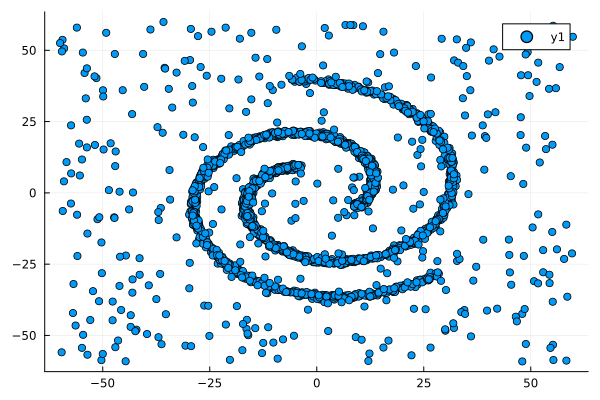

In [5]:
scatter(data.points[1,:],data.points[2,:])

## Computation of the union of ellipsoids with the kPLM function

### Parameters

In [6]:
k = 20        # number of nearest neighbors
c = 30        # number of ellipsoids
iter_max = 20 # maximum number of iterations of the algorithm kPLM
nstart = 5 ;   # number of initializations of the algorithm kPLM

### Method

We decide to make no constraints on the ellipsoids, that is, no constraints on the eigenvalues of the matrices directing the ellipsoids.

In [7]:
function f_Σ!(Σ) end

f_Σ! (generic function with 1 method)

The parameter "indexed_by_r2 = TRUE" is the default parameter in the function kplm. We should not modify it since some birth times are negative.

It is due to the logarithm of the determinant of some matrices that are negative. This problem can be solved by adding constraints to the matrices, with the argument "f_Σ!". In particular, forcing eigenvalues to be non smaller than 1 works.

### Application of the method

In [8]:
df = kplm(rng, data.points, k, c, nsignal, iter_max, nstart, f_Σ!)

KpResult{Float64}:
k = 20
centers = [
     [-13.361080304260424, -13.73719408974299]
     [4.440957955840567, 37.93639493756925]
     [20.987365041409355, -32.47473024525443]
     [29.49270598673868, 16.410576727410668]
     [-23.11934263727861, 11.210928682897059]
     [-2.7016740995966937, -22.42607265459634]
     [-27.346817511441508, 3.2463568461904573]
     [4.359765218960206, 18.456184123025153]
     [-8.8546682907434, -33.46432953601443]
     [-28.102700609977905, -9.824466144947982]
     [27.06692705702217, -11.304857508728581]
     [6.183868326036574, -36.20995574474587]
     [30.751835251406426, -2.497479668634588]
     [11.949884453553823, -22.710090929971443]
     [-3.99916230955154, 0.5937661381062185]
     [21.91176564573949, 28.342788812820512]
     [-11.234320726533932, 6.367750579409677]
     [-6.282930447001969, 8.816205762220573]
     [12.107492050310332, 9.786095438058556]
     [29.033416714528897, -7.747809130367557]
     [-21.638248077544645, -23.65246273278178]
 

## Clustering based on the persistence of the union of ellipsoids filtration

### Matrix of distances

This is a matrix that contains the birth times of the ellipsoids in the diagonal, and the intersecting times of pairs of ellipsoids in the lower left triangular part of the matrix.

In [9]:
mh = build_matrix(df)

27×27 Matrix{Float64}:
    2.15832    Inf         Inf       …  Inf        Inf       Inf
  225.607       2.73385    Inf          Inf        Inf       Inf
   43.7884    353.477       2.53658     Inf        Inf       Inf
 1482.35       16.2502     68.2638      Inf        Inf       Inf
   25.3068    111.083    1071.52        Inf        Inf       Inf
    4.87139  2057.89       29.2883   …  Inf        Inf       Inf
   22.0246     70.7734    216.886       Inf        Inf       Inf
  264.1       173.478     289.061       Inf        Inf       Inf
   32.053    2519.42       12.0303      Inf        Inf       Inf
   46.3711    211.92      118.042       Inf        Inf       Inf
  244.478     360.61      126.572    …  Inf        Inf       Inf
   30.2897   2015.53        5.00671     Inf        Inf       Inf
  485.194     187.75      129.689       Inf        Inf       Inf
    ⋮                                ⋱              ⋮        
 1319.04        6.02369   115.317    …  Inf        Inf       Inf
   19

### Selection of parameter "Seuil"

We draw a persistence diagram based on the filtration of the union of ellipsoids.

Each point corresponds to the connected component of an ellipsoid. The birth time corresponds to the time at which the ellipsoid, and thus the component, appears. The death time corresponds to the time at which the component merges with a component that was born before.

The top left point corresponds to the ellipsoid that appeared first and therefore never merges with a component born before. Its death time is $\infty$.

The parameter "Seuil" aims at removing ellipsoids born after time "Seuil". Such ellipsoids are considered as irrelevant. This may be due to a bad initialisation of the algorithm that creates ellipsoids in bad directions with respect to the data.

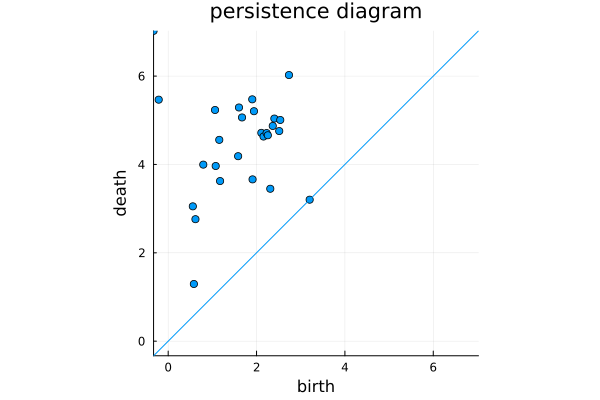

In [10]:
hc = hierarchical_clustering_lem(mh, Stop = Inf, Seuil = Inf, 
                                 store_all_colors = false, 
                                 store_all_step_time = false)

lims = (min(min(hc.Naissance...),min(hc.Mort...)),max(max(hc.Naissance...),max(hc.Mort[hc.Mort.!=Inf]...))+1)
plot(hc,xlims = lims, ylims = lims)

Note that the "+1" in the second argument of lims and lims2 hereafter is to separate
the components whose death time is $\infty$ to other components.

We consider that ellipsoids born after time "Seuil = 3" were not relevant.

### Selection of parameter "Stop"

We then have to select parameter "Stop". Connected components which lifetime is larger than "Stop" are components that we want not to die.

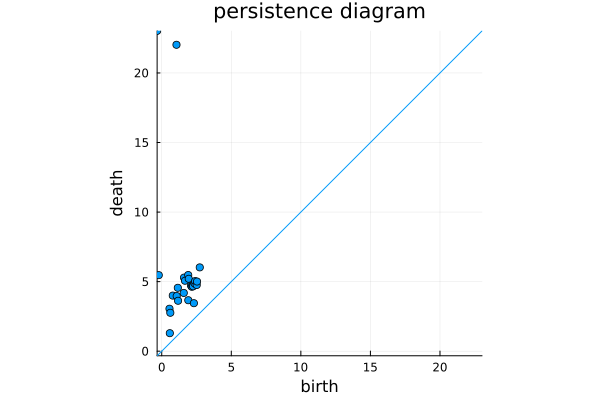

In [11]:
hc2 = hierarchical_clustering_lem(mh, Stop = Inf, Seuil = 3, 
                                 store_all_colors = false, 
                                 store_all_step_time = false)

lims2 = (min(min(hc2.Naissance...),min(hc2.Mort...)),max(max(hc2.Naissance...),max(hc2.Mort[hc2.Mort.!=Inf]...))+1)
plot(hc2,xlims = lims2, ylims = lims2)

We select "Stop = 15". Since there are clearly two connected components that have a lifetime much larger than others. This lifetime is larger than 15, whereas the lifetime of others is smaller than 15.

### Clustering

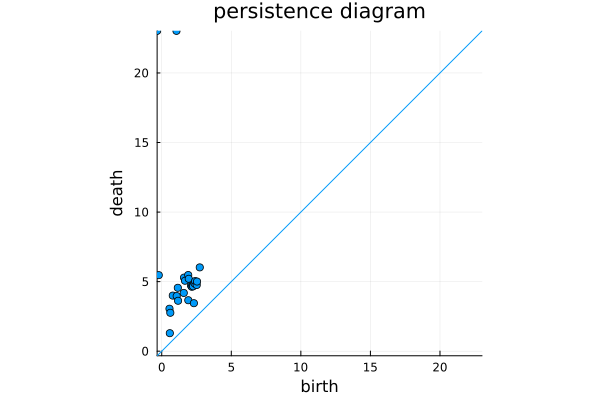

In [12]:
hc3 = hierarchical_clustering_lem(mh, Stop = 15, Seuil = 3, 
                                 store_all_colors = true, 
                                 store_all_step_time = true)

plot(hc3,xlims = lims2, ylims = lims2) # Using the sames xlims and ylims than the previous persistence diagram.

### Getting the number of components, colors of ellipsoids and times of evolution of the clustering

In [13]:
nellipsoids = length(hc3.Indices_depart) # Number of ellipsoids
Col = hc3.Couleurs # Ellispoids colors
Temps = hc3.Temps_step ; # Time at which a component borns or dies

Note : Col[i] contains the labels of the ellipsoids just before the time Temps[i]

Example : 
- Col[1] contains only 0 labels

Moreover, if there are 2 connexed components in the remaining clustering :
- Col[end - 1] = Col[end] contains 2 different labels
- Col[end - 2] contains 3 different labels

Using a parameter Seuil not equal to $\infty$ erases some ellipsoids.
Therefore we need to compute new labels of the data points, with respect to the new ellipsoids.

In [14]:
remain_indices = hc3.Indices_depart
color_points, dists = subcolorize(data.points, npoints, df, remain_indices) 

([24, 4, 14, 6, 4, 16, 23, 1, 23, 24  …  1, 22, 7, 3, 2, 26, 4, 22, 14, 27], [3.0834832253734072, 4.138599640060516, 5.858161803075881, 4.577414288317848, 2.2553107970786277, 2.9531940716931597, 4.895412959673004, 4.5744742441804895, 3.867771184447114, 16.31537457566968  …  257.8891299437349, 69.7622359783785, 162.06131858701644, 88.12872626691839, 417.49686605173906, 218.8424769874933, 127.67779879977877, 35.42710030909008, 17.06133363403088, 290.0052076084895])

## Removing outliers

### Selection of the number of outliers

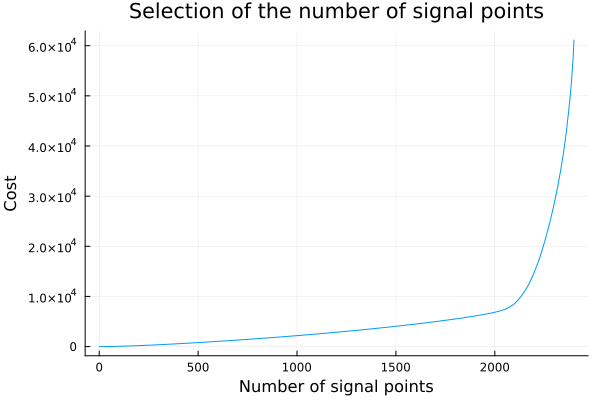

In [15]:
nsignal_vect = 1:npoints
idxs = zeros(Int, npoints)
sortperm!(idxs, dists, rev = false)
costs = cumsum(dists[idxs])
plot(nsignal_vect,costs, title = "Selection of the number of signal points",legend = false)
xlabel!("Number of signal points")
ylabel!("Cost")

We choose "nsignal", the number of points at which there is a slope change in the cost curve.

We set the label of the (npoints - nsignal) points with largest cost to 0. These points are considered as outliers.

In [16]:
nsignal = 2100

if nsignal < npoints
    for i in idxs[(nsignal + 1):npoints]
        color_points[i] = 0
    end
end

### Preparation of the animation

Since "indexed_by_r2 = TRUE", we use sq_time and not its squareroot.

In [20]:
sq_time = (0:200) ./200 .* (Temps[end-1] - Temps[1]) .+ Temps[1] # Depends on "Temps" vector.
Col2 = Vector{Int}[] 
Colors2 = Vector{Int}[]

idx = 0
new_colors2 = zeros(Int, npoints)
new_col2 = zeros(Int, nellipsoids)
next_sqtime = Temps[idx+1]
updated = false

for i = 1:length(sq_time)
    while sq_time[i] >= next_sqtime
        println(idx," ",sq_time[i]," ",next_sqtime," ",Temps[idx+2])
        idx +=1
        next_sqtime = Temps[idx+1]
        updated = true
    end
    if updated
        new_col2 = Col[idx+1]
        new_colors2 = return_color(color_points, new_col2, remain_indices)
        updated = false
    end
    println(i," ",new_col2)
    push!(Col2, copy(new_col2)) ;
    push!(Colors2, copy(new_colors2)) ;
end

for i = 1:length(Col2)
    for j = 1:size(data.points)[2]
        Colors2[i][j] = Colors2[i][j] * (dists[j] <= sq_time[i]) ; # If the cost of the point is smaller to the time : label 0 (not in the ellipsoid)
    end
end

μ = [df.μ[i] for i in remain_indices if i>0] ;
ω = [df.weights[i] for i in remain_indices if i>0] ;
Σ = [df.Σ[i] for i in remain_indices if i>0] ;

ncolors2 = length(Colors2) ;

anim = @animate for i = [1:ncolors2; Iterators.repeated(ncolors2,30)...]
    ellipsoids(data.points, Col2[i], Colors2[i], μ, ω, Σ, sq_time[i]; markersize=5)
    xlims!(-60, 60)
    ylims!(-60, 60)
end ;

0 -0.3309588628208855 -0.3309588628208855 -0.21462950522921426
1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 -0.10740364326317312 -0.21462950522921426 0.557726607621699
3 [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4 [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5 [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6 [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7 [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8 [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2 0.563262015409964 0.557726607621699 0.581550292799536
9 [1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3 0.6750396251888202 0.581550292799536 0.6172043373704265
4 0.6750396251888202 0.617204337

85 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
86 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
87 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
88 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
89 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
90 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
91 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
92 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
93 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
94 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
95 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
96 [1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 7, 1]
97 [1, 1, 1, 1, 

### Animation - Clustering result

┌ Info: Saved animation to /home/claire/Documents/Recherche/Codes/GeometricClusterAnalysis/GeometricClusterAnalysis.jl/examples/Notebooks/anim_kpdtm2.gif
└ @ Plots /home/claire/.julia/packages/Plots/kYFLA/src/animation.jl:149


Plots.AnimatedGif("/home/claire/Documents/Recherche/Codes/GeometricClusterAnalysis/GeometricClusterAnalysis.jl/examples/Notebooks/anim_kpdtm2.gif")
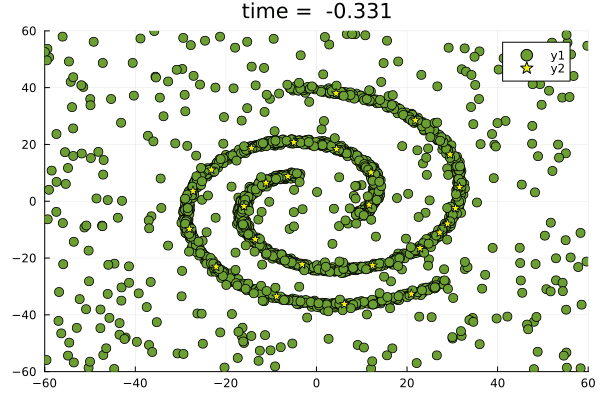

In [18]:
gif(anim, "anim_kpdtm2.gif", fps = 5)